## Airline Sentiment Analysis

#### Import Libraries

In [44]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [57]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix
from xgboost import XGBClassifier


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from gensim.models import Word2Vec


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [16]:
# Load data
data = pd.read_csv('../data/Tweets.csv')
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


#### Data Exploration and Preprocessing

In [3]:
# Check nulls and dtypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [8]:
# Check descriptive statistics
data.describe(include=[object]).T

,count,unique,top,freq
airline_sentiment,14640,3,negative,9178
negativereason,9178,10,Customer Service Issue,2910
airline,14640,6,United,3822
airline_sentiment_gold,40,3,negative,32
name,14640,7701,JetBlueNews,63
negativereason_gold,32,13,Customer Service Issue,12
text,14640,14427,@united thanks,6
tweet_coord,1019,832,"[0.0, 0.0]",164
tweet_created,14640,14247,2015-02-24 09:54:34 -0800,5
tweet_location,9907,3081,"Boston, MA",157


In [17]:
# Extract postice and negatives reviews
data = data.loc[data['airline_sentiment']!= 'neutral']
data = data[["airline_sentiment", "text"]]
data['airline_sentiment'] = data['airline_sentiment'].map({'positive': 1, 'negative': 0})
data

,airline_sentiment,text
1,1,@VirginAmerica plus you've added commercials t...
3,0,@VirginAmerica it's really aggressive to blast...
4,0,@VirginAmerica and it's a really big bad thing...
5,0,@VirginAmerica seriously would pay $30 a fligh...
6,1,"@VirginAmerica yes, nearly every time I fly VX..."
...,...,...
14633,0,@AmericanAir my flight was Cancelled Flightled...
14634,0,@AmericanAir right on cue with the delays👌
14635,1,@AmericanAir thank you we got on a different f...
14636,0,@AmericanAir leaving over 20 minutes Late Flig...


In [21]:
# Download stopwords 
nltk.download('stopwords')
stop_words = stopwords.words('english')

# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /Users/jacob/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
# Function to preprocess and clean text 
def preprocess_text(text):
    # Normalize and remove specaial characters
    text = text.lower()
    text = re.sub('[^0-9a-zA-Z]', ' ', text)
    # Split text and remove stop words
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    # Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    words = ' '.join(words)
    return words


# Preprocess text data
data['text'] = data['text'].apply(preprocess_text)

In [25]:
data['text'].iloc[0:5]

1    virginamerica plus added commercial experience...
3    virginamerica really aggressive blast obnoxiou...
4                   virginamerica really big bad thing
5    virginamerica seriously would pay 30 flight se...
6    virginamerica yes nearly every time fly vx ear...
Name: text, dtype: object

In [26]:
# Extract text and labels 
texts = data['text'].tolist()
labels = data['airline_sentiment'].tolist()

Text(0.5, 1.0, 'Distribution of Sentiments')

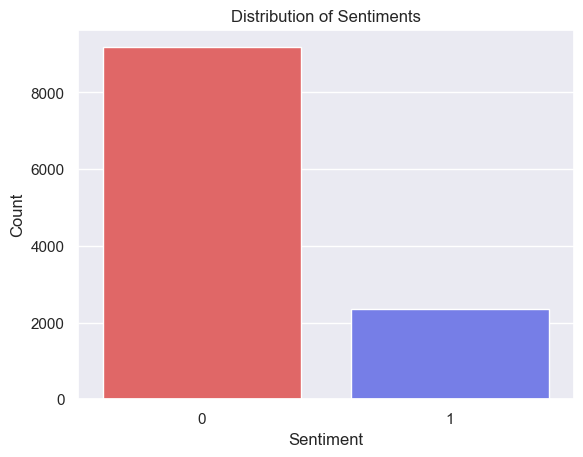

In [39]:
# Create a countplot
sns.set(style="darkgrid")
palette = {1: '#636efa', 0: '#f45353'}  # Define colors for each sentiment
sns.countplot(x=labels, palette=palette)

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')

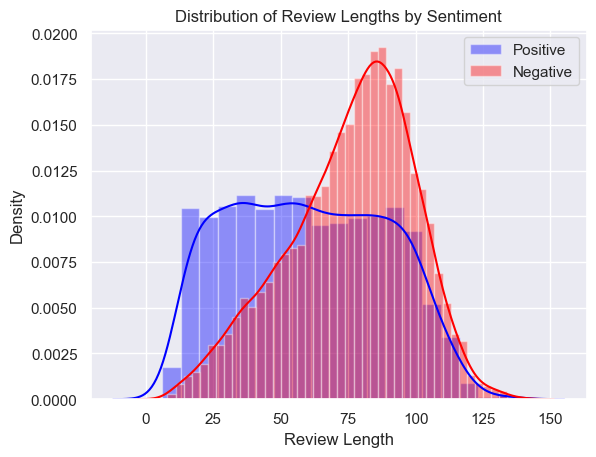

In [46]:
# Calculate the lengths of the reviews
positive_lengths = [len(text) for text, label in zip(texts, labels) if label == 1]
negative_lengths = [len(text) for text, label in zip(texts, labels) if label == 0]

# Create distplot
sns.distplot(positive_lengths, label='Positive', color='blue')
sns.distplot(negative_lengths, label='Negative',color='red')

plt.xlabel('Review Length')
plt.ylabel('Density')
plt.title('Distribution of Review Lengths by Sentiment')
plt.legend()

plt.show()


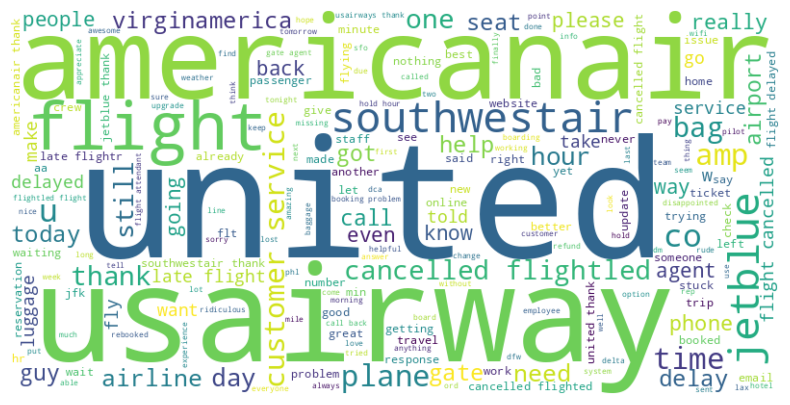

In [47]:
from wordcloud import WordCloud

# Combine all texts into a single string
all_text = ' '.join(texts)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the generated word cloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# Show the plot
plt.show()

#### Vectorization

In [51]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform
X = tfidf_vectorizer.fit_transform(texts)


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)


#### Model Experimentation

In [52]:
# Intialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Evaluate model
accuracy = rf.score(X_test, y_test)
print(f'Accuracy - Random Forest: {accuracy * 100:.2f}%')


Accuracy - Random Forest: 90.18%


In [56]:
# Intialize XgboostClassifier 
xgb_model = XGBClassifier(random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Evaluate model
accuracy = xgb_model.score(X_test, y_test)
print(f'Accuracy - XGBoostClassifier: {accuracy * 100:.2f}%')

Accuracy - XGBoostClassifier: 90.33%


In [58]:
# Hyperparameter tuning using GridSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5]
}

In [59]:
# Intialize XgboostClassifier 
xgb_model = XGBClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)

# Train the GridSearch
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'gamma': [0, 1, 5], 'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='accuracy')

In [60]:
# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [62]:
# Evaluate the model
accuracy = best_model.score(X_test, y_test)
print(f'Accuracy of XGBoost: {accuracy * 100:.2f}%')
print(f'Best Hyperparameters: {best_params}')

Accuracy of XGBoost: 90.50%
Best Hyperparameters: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.9}


#### Model Evalutation

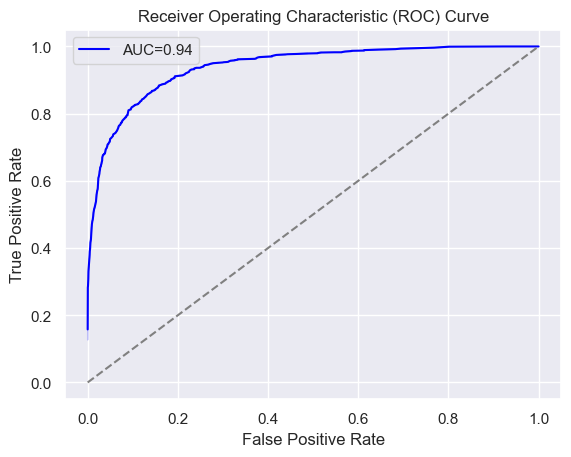

In [70]:
from sklearn.metrics import roc_curve, auc

# get the predicted probabilities of class 1
predicted = best_model.predict_proba(X_test)[:,1] 

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predicted)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
sns.set_style("darkgrid")
roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
sns.lineplot(data=roc_df, x='fpr', y='tpr', color='blue', label=f'AUC={roc_auc:.2f}')
sns.lineplot(x=[0, 1], y=[0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Text(0.5, 1.0, 'Accuracy Score for XGBoost Classifier: 0.9049956684955242')

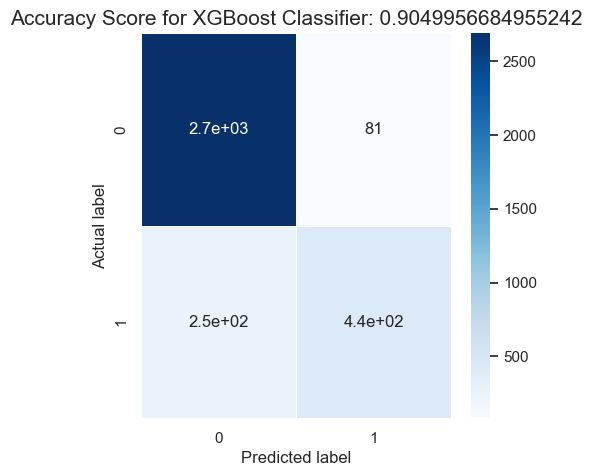

In [71]:
# Display confusion matrix
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score for XGBoost Classifier: {0}'.format(best_model.score(X_test, y_test))
plt.title(all_sample_title, size = 15)

#### Model Prediction

In [69]:
# Make predictions
predictions = best_model.predict(X_test)

# Create a list of positive and negative sentences based on predicted labels 
positive_sentences = [X_test[i] for i in range(len(predictions)) if predictions[i] == 1]
negative_sentences = [X_test[i] for i in range(len(predictions)) if predictions[i] == 0]

# Convert the sentences back to their original text form
positive_texts = [tfidf_vectorizer.inverse_transform(sentence)[0] for sentence in positive_sentences]
negative_texts = [tfidf_vectorizer.inverse_transform(sentence)[0] for sentence in negative_sentences]

# Print the first 5 positive and negative texts
print("Positive Texts:")
for text in positive_texts[:5]:
    print(' '.join(text))

print("\nNegative Texts:")
for text in negative_texts[:5]:
    print(' '.join(text))


Positive Texts:
co flight great http jetblue view
ago airport busiest club month none one thank united weird
americanair followed great thanks
got thanks united
a320 airbus bostonlogan co gate http jetblue jetbluesofly morning pulling sunrise

Negative Texts:
cancelled charged flight flightled unbelievable usairways
actually agent awful booking flight gate line missed problem reflight rude standing sti united waiting
200 aa additional americanair asleep back called everything fee flightr gr8 hr late standard took worry
2015 airline brother country cross cup flight help lost luggage panamerican please sunday united
flow hard keeping making positive smoothly sure thing usairways work


#### Deep Learning approach